In [1]:
"""
    - Use feature
        - ZCR
        - chroma sftp
        - MFCC
        - RMS
        - MelSpectogram
        - tonnetz
    
    - Data augmetation
        - noise
        - pitch
        - stretch
"""

'\n    - Use feature\n        - ZCR\n        - chroma sftp\n        - MFCC\n        - RMS\n        - MelSpectogram\n        - tonnetz\n    \n    - Data augmetation\n        - noise\n        - pitch\n        - stretch\n'

In [2]:
import pandas as pd
import numpy as np

import os
import sys


import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio


import tensorflow.keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import np_utils
from tqdm.auto import tqdm
from pathlib import Path

In [3]:
# Paths for data.
Ravdess = "./dataset/"

In [4]:
def prepare_RAVDESS_DS(path_audios):
    """
    Generation of the dataframe with the information of the dataset. The dataframe has the following structure:
     ______________________________________________________________________________________________________________________________
    |             name            |                     path                                   |     emotion      |     actor     |
    ______________________________________________________________________________________________________________________________
    |  01-01-01-01-01-01-01.wav   |    <RAVDESS_dir>/audios_16kHz/01-01-01-01-01-01-01.wav     |     Neutral      |     1         |
    ______________________________________________________________________________________________________________________________
    ...
    :param path_audios: Path to the folder that contains all the audios in .wav format, 16kHz and single-channel(mono)
    """
    data = []
    for path in tqdm(Path(path_audios).glob("**/*.wav")):
        name = str(path).split('/')[-1].split('.')[0]
        label = int(name.split("-")[2])  # Start emotions in 0
        actor = int(name.split("-")[-1])

        try:
            data.append({
                "Path": path,
                "Emotions": label
            })
        except Exception as e:
            # print(str(path), e)
            pass
    df = pd.DataFrame(data)
    return df

Ravdess_df = prepare_RAVDESS_DS('dataset')

# changing integers to actual emotions.
# Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

0it [00:00, ?it/s]

,Path,Emotions
0,dataset\Actor_01\03-01-01-01-01-01-01.wav,1
1,dataset\Actor_01\03-01-01-01-01-02-01.wav,1
2,dataset\Actor_01\03-01-01-01-02-01-01.wav,1
3,dataset\Actor_01\03-01-01-01-02-02-01.wav,1
4,dataset\Actor_01\03-01-02-01-01-01-01.wav,2


In [5]:
data_path = Ravdess_df
data_path.to_csv("data_path.csv",index=False)
data_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Path      1440 non-null   object
 1   Emotions  1440 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.6+ KB


In [6]:
#checking for the data
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

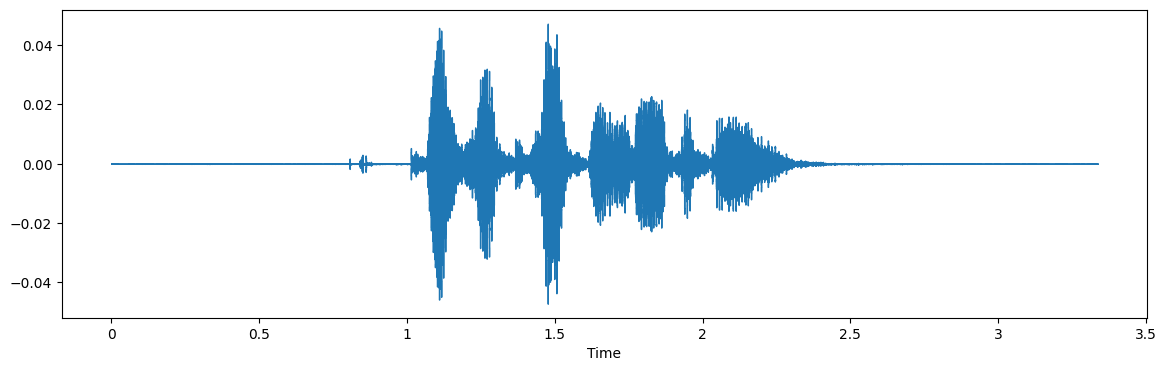

In [7]:
#visualizing a single audio file
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)


In [8]:
#DATA AUGMENTATION

def noise(data):
    noise_amp = 0.025*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.6):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [9]:
 def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally matlab equivalent result = [result zcr]

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    # tonnetz
    tonn = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonn)) #stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result # +1440*3 is our new number of data (number of rows) and columns are 6 features extracted.

In [10]:
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
stft = np.abs(librosa.stft(data))
chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

feature = get_features(path)

feature.shape

C:\Users\devLupin\miniconda3\envs\tf_env\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=862
  return f(*args, **kwargs)
C:\Users\devLupin\miniconda3\envs\tf_env\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=862
  return f(*args, **kwargs)
C:\Users\devLupin\AppData\Local\Temp\ipykernel_2420\1375846852.py:9: FutureWarning: Pass rate=0.6 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)
C:\Users\devLupin\AppData\Local\Temp\ipykernel_2420\1375846852.py:16: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


(3, 168)

In [11]:
path = np.array(data_path.Path)[1]
path

WindowsPath('dataset/Actor_01/03-01-01-01-01-02-01.wav')

In [12]:
#checking the shapes of the features
print(zcr.shape)
print(chroma_stft.shape)
print(mfcc.shape)
print(mfcc.shape)
print(mel.shape)

(1,)
(12,)
(20,)
(20,)
(128,)


In [13]:
X, Y = [], []
for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions)):
    feature = get_features(path) # outputs result matrix (1data*3) * (6)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

0it [00:00, ?it/s]

C:\Users\devLupin\AppData\Local\Temp\ipykernel_2420\1375846852.py:9: FutureWarning: Pass rate=0.6 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)
C:\Users\devLupin\AppData\Local\Temp\ipykernel_2420\1375846852.py:16: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
C:\Users\devLupin\miniconda3\envs\tf_env\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=851
  return f(*args, **kwargs)
C:\Users\devLupin\miniconda3\envs\tf_env\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=817
  return f(*args, **kwargs)
C:\Users\devLupin\miniconda3\envs\tf_env\lib\site-packages\librosa\util\decorators.py:88: UserWarning:

In [14]:
len(X), len(Y), data_path.Path.shape


(4320, 4320, (1440,))

In [15]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,labels
0,0.283226,0.739174,0.760110,0.738748,0.712194,0.687986,0.667279,0.694000,0.742275,0.762594,...,1.324619e-06,1.469305e-07,3.053402e-09,-0.039355,0.017558,-0.038868,-0.058687,0.016278,0.011009,1
1,0.295442,0.783582,0.800235,0.792940,0.792791,0.788456,0.691867,0.677410,0.718440,0.757947,...,1.396307e-05,1.216602e-05,1.206483e-05,-0.013871,0.000961,-0.044455,0.007651,-0.000877,0.005132,1
2,0.171248,0.651160,0.658097,0.711892,0.668191,0.617453,0.643802,0.654371,0.668990,0.701244,...,2.100173e-07,2.322223e-08,6.716370e-11,0.018731,-0.025561,0.027073,-0.077162,0.002583,-0.004527,1
3,0.254530,0.676571,0.724970,0.725722,0.668644,0.645344,0.671470,0.631493,0.681748,0.709889,...,2.024577e-06,1.944936e-07,2.701240e-09,-0.068995,0.034249,-0.058554,-0.055766,0.014253,-0.005258,1
4,0.312202,0.778805,0.808657,0.781866,0.777926,0.792642,0.713962,0.660149,0.702086,0.736154,...,6.206755e-05,5.859838e-05,6.298549e-05,-0.017174,0.007724,-0.059364,0.000669,0.002737,-0.005260,1


In [16]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

# one hot encoding our y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [17]:
#train test split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 168), (3240, 8), (1080, 168), (1080, 8))

In [18]:
#normalizes the data by -miu/std.dev
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 168), (3240, 8), (1080, 168), (1080, 8))

In [19]:
from numpy import savetxt

savetxt('xtest.csv', x_test, delimiter=',')
savetxt('xtrain.csv', x_train, delimiter = ',')

savetxt('ytest.csv', y_test, delimiter=',')
savetxt('ytrain.csv', y_train, delimiter = ',')

In [20]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 168, 1), (3240, 8), (1080, 168, 1), (1080, 8))

In [21]:
#the convolutional neural network that we are going to use

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 168, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 84, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 84, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 42, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 42, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 128)           0

In [22]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=3, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=256, epochs=150, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/150
13/13 [==============================] - 3s 40ms/step - loss: 2.0135 - accuracy: 0.1738 - val_loss: 1.9098 - val_accuracy: 0.2667
Epoch 2/150
13/13 [==============================] - 0s 11ms/step - loss: 1.9505 - accuracy: 0.2170 - val_loss: 1.8650 - val_accuracy: 0.2935
Epoch 3/150
13/13 [==============================] - 0s 11ms/step - loss: 1.9245 - accuracy: 0.2352 - val_loss: 1.8324 - val_accuracy: 0.2944
Epoch 4/150
13/13 [==============================] - 0s 12ms/step - loss: 1.8884 - accuracy: 0.2611 - val_loss: 1.7916 - val_accuracy: 0.3287
Epoch 5/150
13/13 [==============================] - 0s 11ms/step - loss: 1.8449 - accuracy: 0.2738 - val_loss: 1.7427 - val_accuracy: 0.3528
Epoch 6/150
13/13 [==============================] - 0s 11ms/step - loss: 1.8088 - accuracy: 0.2907 - val_loss: 1.6888 - val_accuracy: 0.3556
Epoch 7/150
13/13 [==============================] - 0s 11ms/step - loss: 1.7785 - accuracy: 0.3096 - val_loss: 1.6589 - val_accuracy: 0.3657
Epoch 

13/13 [==============================] - 0s 11ms/step - loss: 0.0738 - accuracy: 0.9769 - val_loss: 1.2861 - val_accuracy: 0.7306
Epoch 116/150
13/13 [==============================] - 0s 11ms/step - loss: 0.0714 - accuracy: 0.9765 - val_loss: 1.2776 - val_accuracy: 0.7296
Epoch 117/150
13/13 [==============================] - 0s 11ms/step - loss: 0.0680 - accuracy: 0.9812 - val_loss: 1.2785 - val_accuracy: 0.7324
Epoch 118/150
13/13 [==============================] - 0s 11ms/step - loss: 0.0677 - accuracy: 0.9809 - val_loss: 1.2828 - val_accuracy: 0.7315
Epoch 119/150
13/13 [==============================] - 0s 11ms/step - loss: 0.0755 - accuracy: 0.9796 - val_loss: 1.2848 - val_accuracy: 0.7306
Epoch 120/150
13/13 [==============================] - 0s 11ms/step - loss: 0.0678 - accuracy: 0.9806 - val_loss: 1.2800 - val_accuracy: 0.7306
Epoch 121/150
13/13 [==============================] - 0s 11ms/step - loss: 0.0697 - accuracy: 0.9796 - val_loss: 1.2840 - val_accuracy: 0.7324
Epoch 

In [23]:
model_save_path = 'pth/312weight.h5'
model.save_weights(model_save_path)

In [24]:
x_test.shape

(1080, 168, 1)

In [25]:
y_test.shape

(1080, 8)

In [26]:
print("Accuracy on validation : " , model.evaluate(x_test,y_test)[1]*100 , "%")

34/34 [==============================] - 0s 4ms/step - loss: 1.2881 - accuracy: 0.7269
Accuracy on validation :  72.68518805503845 %


Text(0.5, 0, 'Epochs')

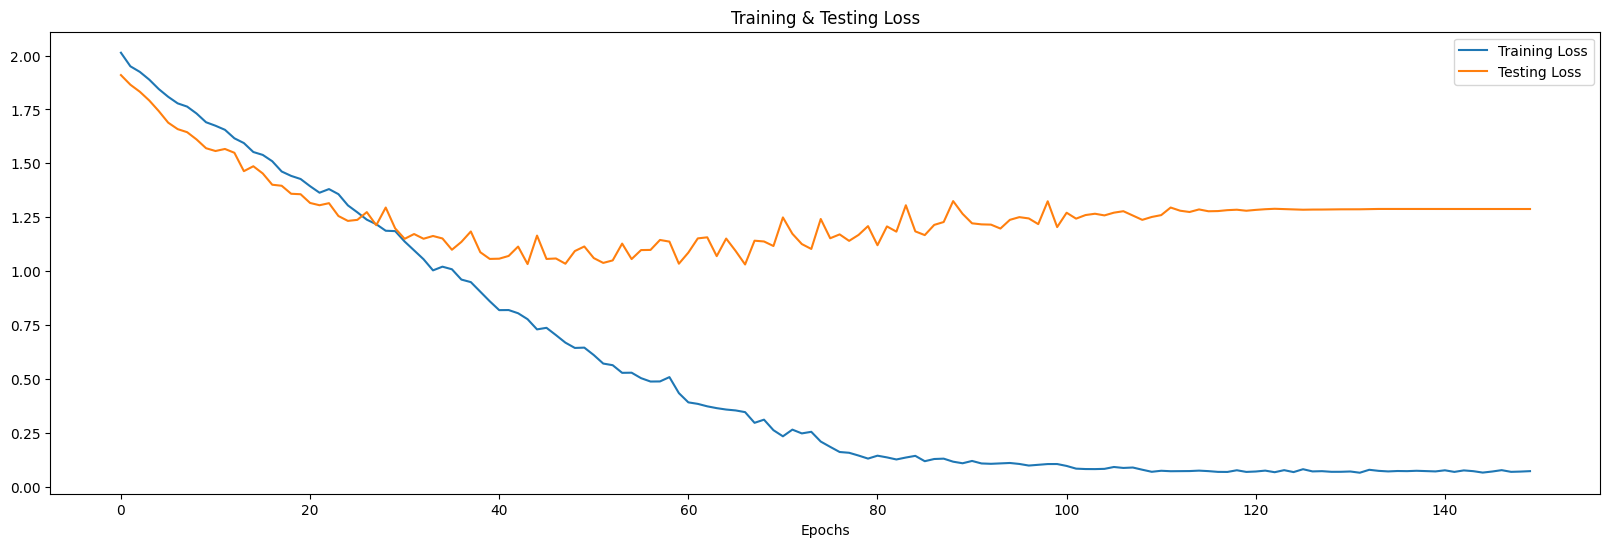

In [27]:
#visual aid of how the metrics vary with accuracy
#plotting the losses

epochs = [i for i in range(150)]
fig , axis = plt.subplots(1,1)


train_loss = history.history['loss']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
axis.plot(epochs , train_loss , label = 'Training Loss')
axis.plot(epochs , test_loss , label = 'Testing Loss')
axis.set_title('Training & Testing Loss')
axis.legend()
axis.set_xlabel("Epochs")

# plt.savefig('Losses.png')

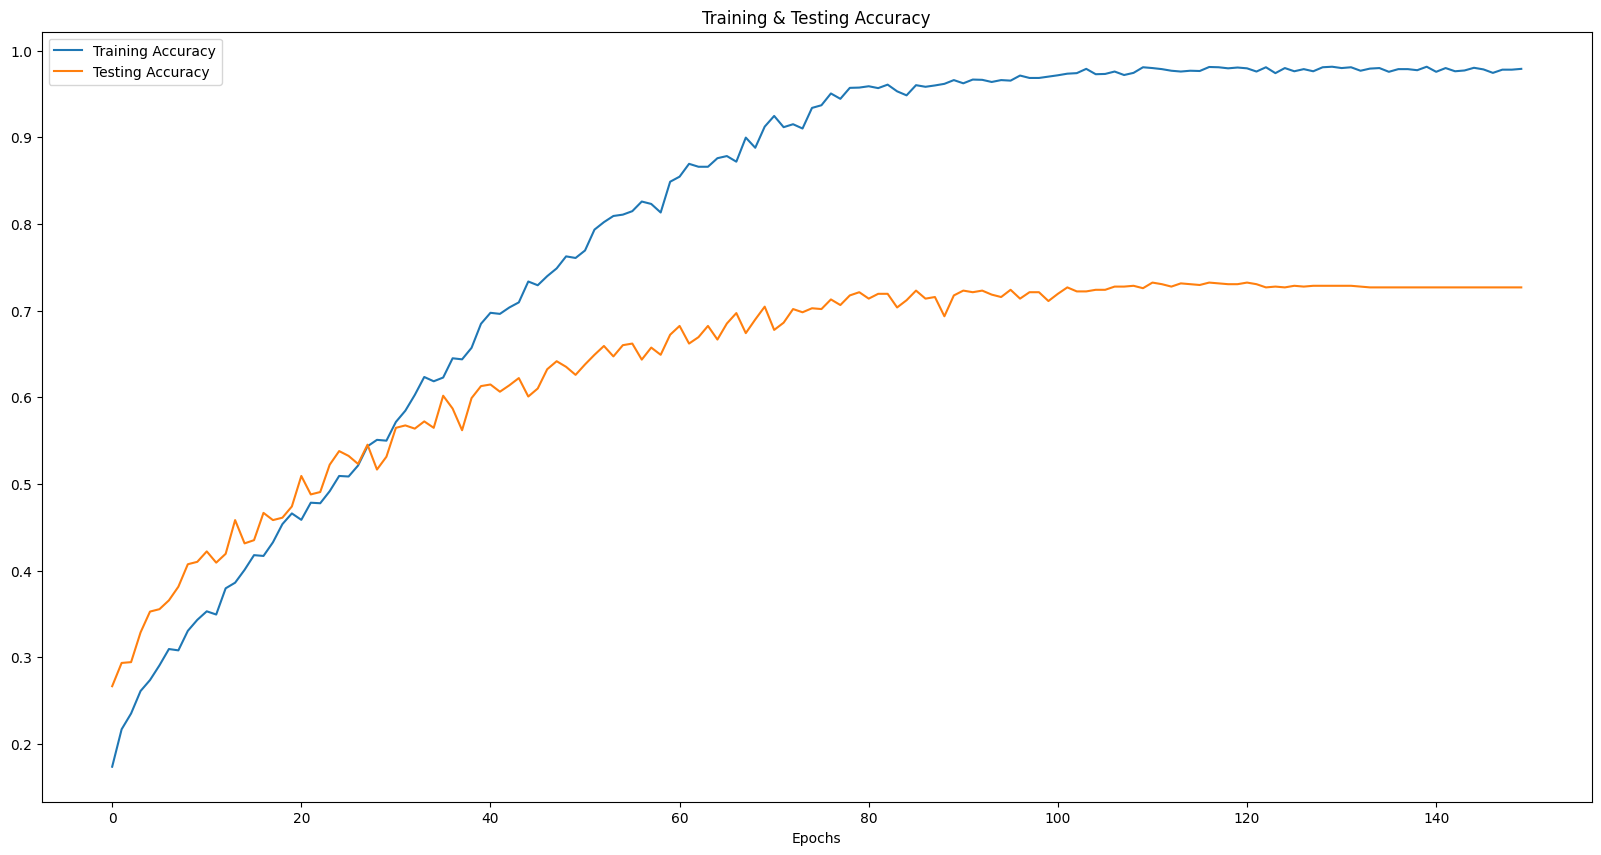

In [28]:
#plotting the accuracy of the training and the validation set
fig , axis = plt.subplots(1,1)

train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

fig.set_size_inches(20,10)
axis.plot(epochs , train_accuracy , label = 'Training Accuracy')
axis.plot(epochs , test_accuracy , label = 'Testing Accuracy')
axis.set_title('Training & Testing Accuracy')
axis.legend()
axis.set_xlabel("Epochs")
plt.show()

# plt.savefig('Accuracy_.png')

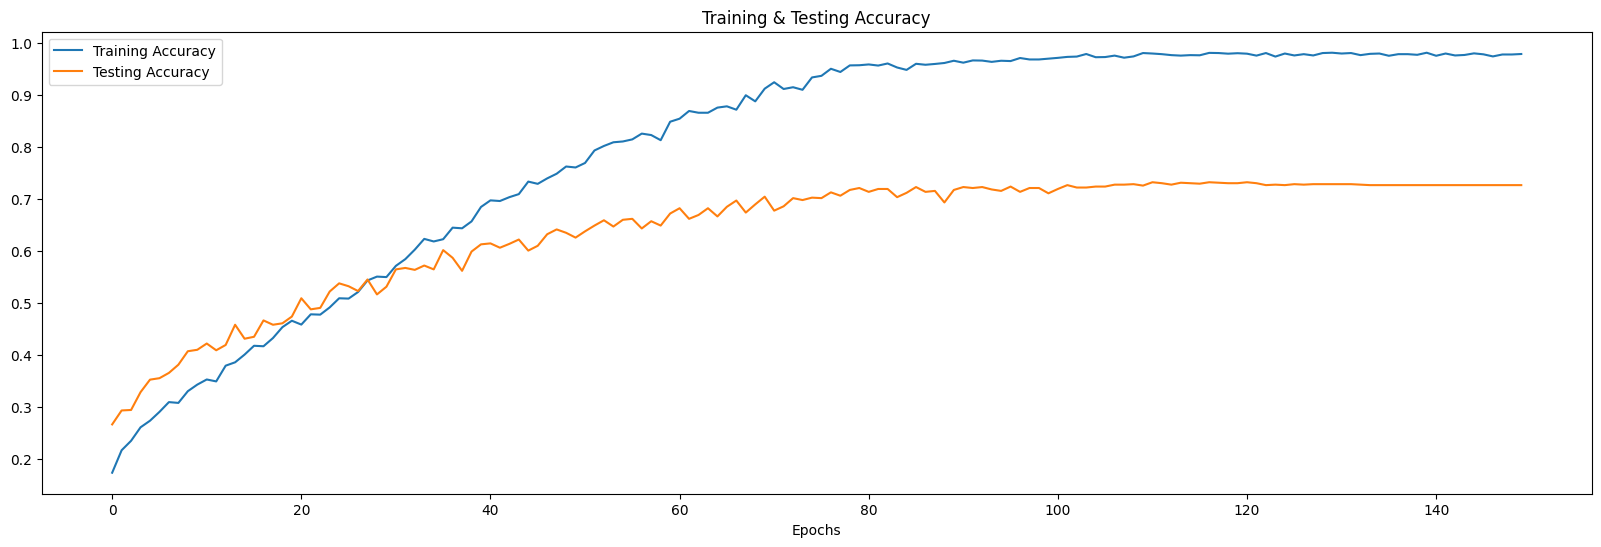

In [29]:
#plotting the accuracy of the training and the validation set
fig , axis = plt.subplots(1,1)

train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

fig.set_size_inches(20,6)
axis.plot(epochs , train_accuracy , label = 'Training Accuracy')
axis.plot(epochs , test_accuracy , label = 'Testing Accuracy')
axis.set_title('Training & Testing Accuracy')
axis.legend()
axis.set_xlabel("Epochs")
plt.show()

# plt.savefig('Accuracies.png')

In [30]:
 # Loads the weights #for pretrained weights see our directory
    
model.load_weights(model_save_path)

# Re-evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

34/34 - 0s - loss: 1.2881 - accuracy: 0.7269
Restored model, accuracy: 72.69%


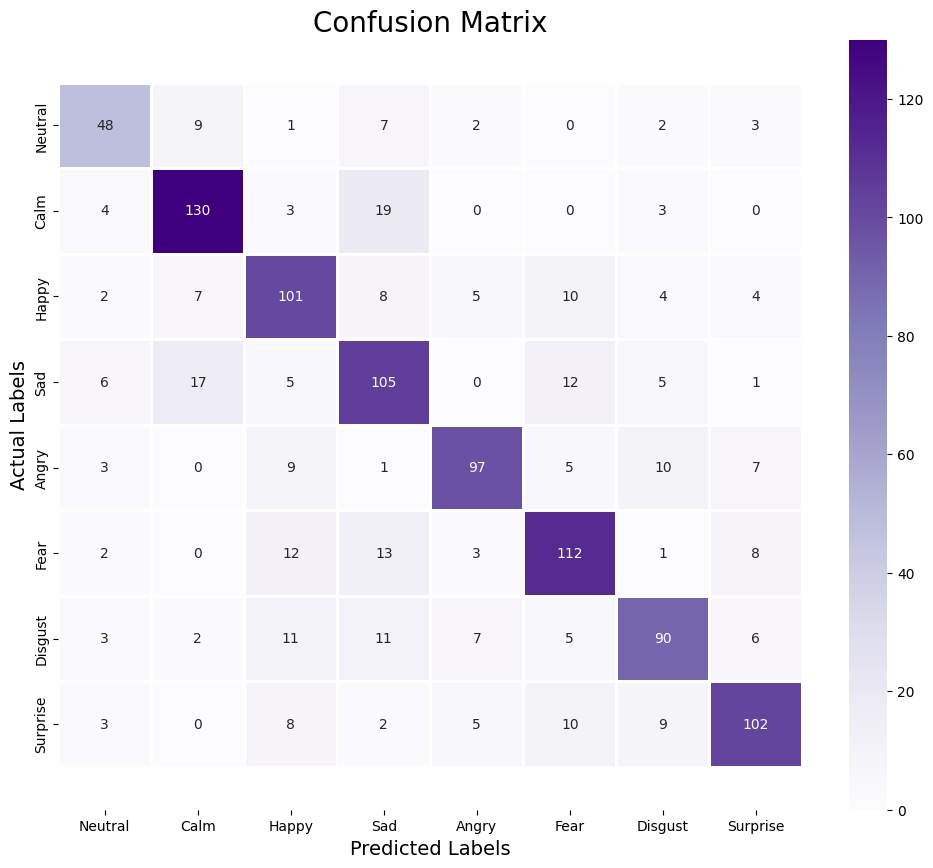

In [31]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

pred = model.predict(x_test)
pred = tf.argmax(pred, axis=1)
y = y_test
y = tf.argmax(y, axis=1)

matrix = confusion_matrix(y, pred)

plt.figure(figsize = (12, 10))
matrix = pd.DataFrame(matrix , index = ["Neutral","Calm","Happy","Sad","Angry","Fear","Disgust","Surprise"] , columns = ["Neutral","Calm","Happy","Sad","Angry","Fear","Disgust","Surprise"])
ax = sns.heatmap(matrix, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()